In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import matplotlib.pyplot as plt
from symmetry_lens import *

2024-11-14 17:35:47.601362: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 17:35:47.632856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 17:35:47.632886: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 17:35:47.632905: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 17:35:47.639326: I tensorflow/core/platform/cpu_feature_g

In [2]:
MODEL_PATH = "model_weights/ep8.h5"
NUM_TRAINING_EPOCHS = 10000
BATCH_SIZE = 17150
OUTPUT_REPRESENTATION = "natural"
SYNTHETIC_DATASET_FEATURES = [
    {
        "type": "gaussian",
        "scale_x_min": 0.5,
        "scale_x_max": 1.5,
        "scale_y_min": 0.5,
        "scale_y_max": 1.5,
        "amplitude_min": 0.5,
        "amplitude_max": 1.5
    }
]
LATENT_X_DIMS = 7
LATENT_Y_DIMS = 7
ZERO_PADDING_SIZE = LATENT_X_DIMS * LATENT_Y_DIMS
NOISE_STD = 0.05
WAVEFORM_TIMESTEPS=33

In [3]:
# Creating a data generator. You may plug your own data generator here. 
dg = make_data_generator(dims=2,
                         batch_size=BATCH_SIZE,
                         features=SYNTHETIC_DATASET_FEATURES,
                         latent_x_dims=LATENT_X_DIMS,
                         latent_y_dims=LATENT_Y_DIMS,
                         output_representation=OUTPUT_REPRESENTATION)

In [4]:
# Create model and load weights.
x_init = np.random.normal(size=(BATCH_SIZE, LATENT_X_DIMS * LATENT_Y_DIMS, 1))
model = create_model(dims=2,
                     zero_padding_size=ZERO_PADDING_SIZE,
                     use_zero_padding=True,
                     n_x_size=LATENT_X_DIMS,
                     n_y_size=LATENT_Y_DIMS)
model.compile()
model(x_init)
model.load_weights(MODEL_PATH)

2024-11-14 17:35:49.631950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22212 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6
2024-11-14 17:35:50.013352: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-14 17:35:52.616065: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x563e24dfa120


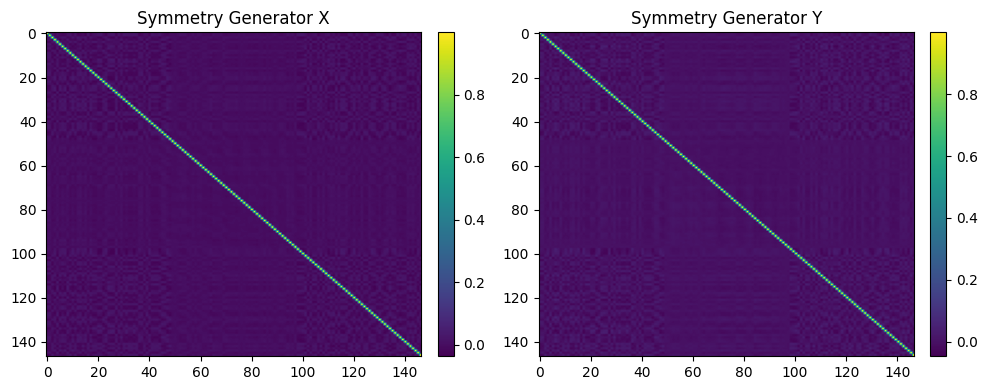

In [6]:
# Plot learned symmetry generator and group correlation map. 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

im1 = ax[0].imshow(model.x_symmetry_generator, aspect="auto", cmap="viridis")
ax[0].set_title("Symmetry Generator X")  # Add title to the first subplot

im2 = ax[1].imshow(model.y_symmetry_generator, aspect="auto", cmap="viridis")
ax[1].set_title("Symmetry Generator Y")  # Add title to the second subplot

fig.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)

# Adjust layout for better spacing
plt.tight_layout()

In [7]:
x = dg.sample_batch_of_data()
print("Batch shape:", x.shape)  # Expected: (BATCH_SIZE, WAVEFORM_TIMESTEPS, 1)
y = model(x)
y = y.numpy()

Batch shape: (17150, 49, 1)


In [8]:
# Randomly select some samples.
random_seed = 42
np.random.seed(random_seed)
total_samples = x.shape[0]
num_pairs = 9
selected_indices = np.random.choice(total_samples, size=num_pairs, replace=False)
print("Selected indices:", selected_indices)

Selected indices: [ 5762  5620  5174  3692 16742  3706  4755  6087  8583]


ValueError: x and y must have same first dimension, but have shapes (33,) and (49,)

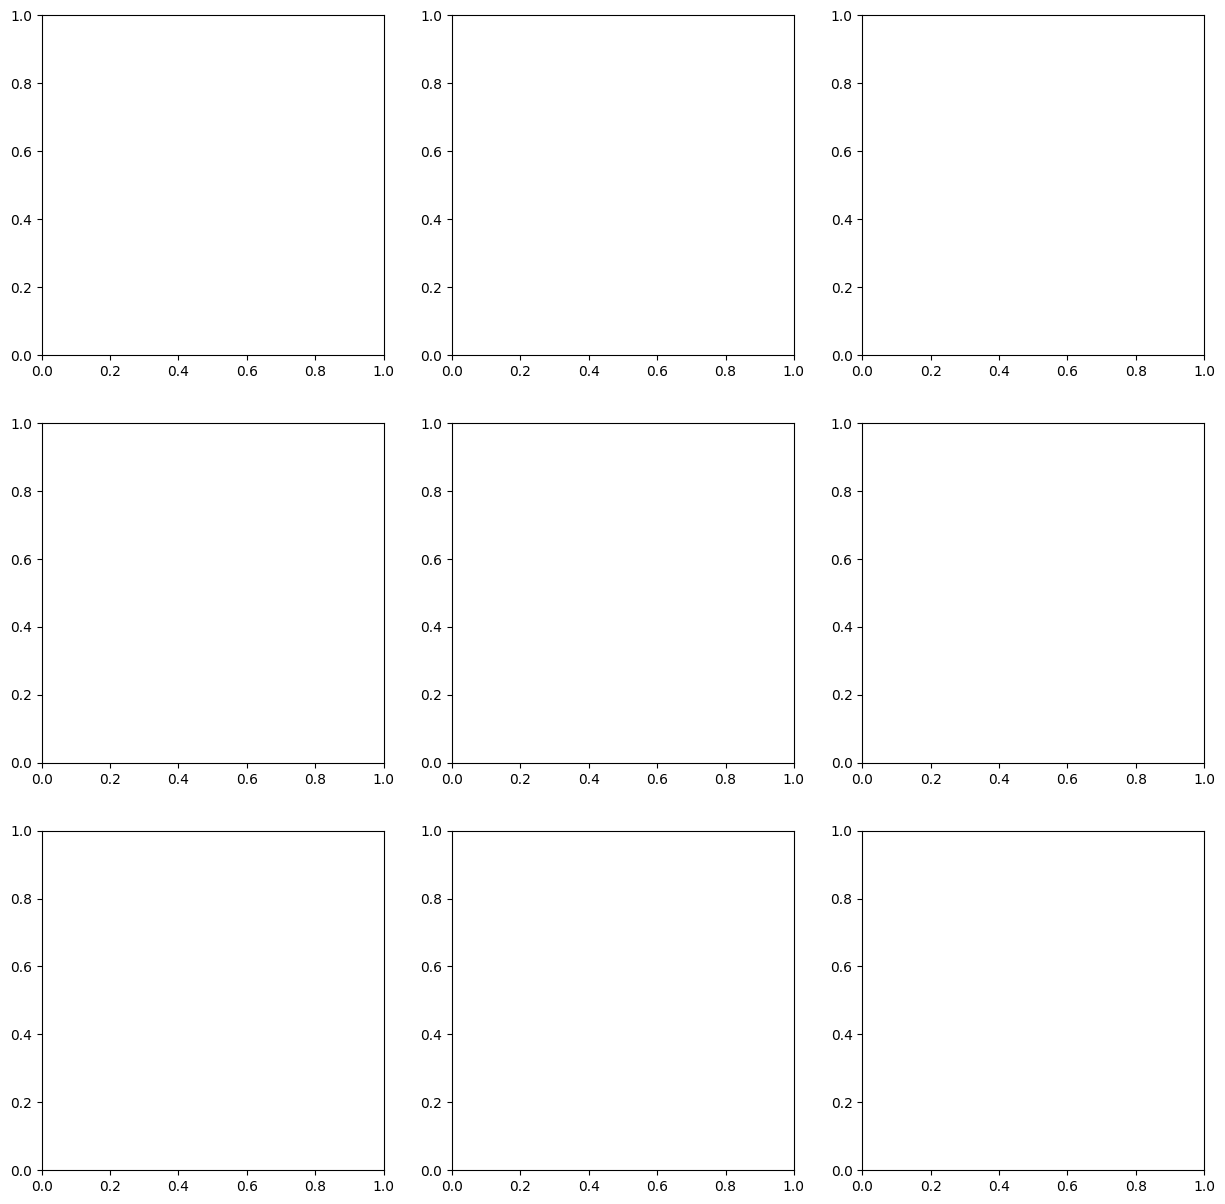

In [9]:
# Plot pairs of inputs and outputs.
# Number of samples to plot
num_samples = len(selected_indices)

# Create subplots: two columns (input and output) and as many rows as samples
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(12, 5 * num_samples))

# Ensure axes is a 2D array even if there's only one sample
if num_samples == 1:
    axes = np.array([axes])

for i, idx in enumerate(selected_indices):
    # Extract input vector and output image
    input_signal = x[idx].squeeze()       # Shape: (N_X_SIZE * N_Y_SIZE,)
    output_image = y[idx].squeeze()       # Shape: (N_X_SIZE, N_Y_SIZE)
    
    # Plot input as a line plot
    input_ax = axes[i, 0]
    timesteps = np.arange(len(input_signal))
    input_ax.plot(timesteps, input_signal, color='red')
    input_ax.set_title(f'Input Signal (Index: {idx})')
    input_ax.set_xlabel('Index')
    input_ax.set_ylabel('Signal Value')
    input_ax.grid(True)
    
    # Plot output as a heatmap
    output_ax = axes[i, 1]
    c = output_ax.imshow(output_image, cmap='viridis', aspect='auto')
    output_ax.set_title(f'Output Heatmap (Index: {idx})')
    output_ax.set_xlabel('X axis')
    output_ax.set_ylabel('Y axis')
    fig.colorbar(c, ax=output_ax)

plt.tight_layout()
plt.show()
plt.clf()